In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt
#from testCases_v2 import *
#from public_tests import *
import sklearn
import sklearn.datasets
import sklearn.linear_model
#from planar_utils import plot_decision_boundary, sigmoid, load_planar_dataset, load_extra_datasets
def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)
    

def sigmoid(x):
    s = 1/(1+np.exp(-x))
    return s

def load_planar_dataset():
    np.random.seed(1)
    m = 400 # number of examples
    N = int(m/2) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros((m,1), dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 4 # maximum ray of the flower

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
        r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j
        
    X = X.T
    Y = Y.T

    return X, Y

def load_extra_datasets():  
    N = 200
    noisy_circles = sklearn.datasets.make_circles(n_samples=N, factor=.5, noise=.3)
    noisy_moons = sklearn.datasets.make_moons(n_samples=N, noise=.2)
    blobs = sklearn.datasets.make_blobs(n_samples=N, random_state=5, n_features=2, centers=6)
    gaussian_quantiles = sklearn.datasets.make_gaussian_quantiles(mean=None, cov=0.5, n_samples=N, n_features=2, n_classes=2, shuffle=True, random_state=None)
    no_structure = np.random.rand(N, 2), np.random.rand(N, 2)
    
    return noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
X, Y = load_planar_dataset()

In [3]:
X.shape

(2, 400)

In [4]:
Y.shape

(1, 400)

In [5]:
def layersize(X,Y):
    nx = X.shape[0]
    ny = Y.shape[0]
    nh = 5
    
    s = {
        "nx":nx,
        "nh":nh,
        "ny":ny
        }
    return s

In [6]:
def initialization(s):
    s = layersize(X,Y)
    nx = s["nx"]
    ny = s["ny"]
    nh = s["nh"]
    W1 = np.random.randn(nh,nx)*0.01
    b1 = np.zeros((nh,1))
    W2 = np.random.randn(ny,nh)*0.01
    b2 = np.zeros((ny,1))
    p = {
        "W1" : W1,
        "b1" : b1,
        "W2" : W2,
        "b2" : b2
        }
    return p

In [7]:
def fpropogation(X,p):
    W1 = p["W1"]
    b1 = p["b1"]
    W2 = p["W2"]
    b2 = p["b2"]
    
    Z1 = np.dot(W1,X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2,A1) + b2
    A2 = sigmoid(Z2)
    
    c = {
        "Z1" : Z1,
        "A1" : A1,
        "Z2" : Z2,
        "A2" : A2
        }
    return c

In [8]:
def Cost(c,Y):
    A2 = c["A2"]
    m = Y.shape[1]
    logterms = np.multiply(np.log(A2),Y) + np.multiply(np.log(1-A2),1-Y)
    cost = -np.sum(logterms)/m
    return cost

In [9]:
def bpropogation(X,Y,p,c):
    W1 = p["W1"]
    W2 = p["W2"]
    A1 = c["A1"]
    A2 = c["A2"]
    m = X.shape[1]
    
    dZ2 = A2-Y
    dW2 = np.dot(dZ2,A1.T)/m
    db2 = np.sum(dZ2,axis=1,keepdims=True)
    dZ1 = np.dot(W2.T,dZ2)*(1-np.power(A1,2))
    dW1 = np.dot(dZ1,X.T)/m
    db1 = np.sum(dZ1,axis=1,keepdims=True)/m
    g = {
        "dW2":dW2,
        "db2":db2,
        "dW1":dW1,
        "db1":db1
    }
    return g

In [10]:
def uparameters(p,g,lr):
    W1 = copy.deepcopy(p["W1"])
    b1 = p["b1"]
    W2 = copy.deepcopy(p["W2"])
    b2 = p["b2"]
    
    dW2 = g["dW2"]
    dW1 = g["dW1"]
    db2 = g["db2"]
    db1 = g["db1"]
    
    W1 = W1 - lr*dW1
    W2 = W2 - lr*dW2
    b1 = b1 - lr*db1
    b2 = b2 - lr*db2

    p = {
        "W1":W1,
        "W2":W2,
        "b1":b1,
        "b2":b2   
        }
    return p

In [11]:
def nnmodel(X,Y,I,printcost,lr):
    np.random.seed(3)
    s = layersize(X,Y)
    nx = s["nx"]
    ny = s["ny"]
    nh = s["nh"]
    p = initialization(s)
    
    for i in range(0,I):
        c = fpropogation(X,p)
        cost = Cost(c,Y)
        g = bpropogation(X,Y,p,c)
        p = uparameters(p,g,lr)
        if printcost and i % 10000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
            
    return p


In [12]:
up = nnmodel(X,Y,200000,True,0.021512)

Cost after iteration 0: 0.693082
Cost after iteration 190000: 0.187236


In [13]:
def predict(p,X):
    c = fpropogation(X,p)
    A2 = c["A2"]
    predictions = (A2 > 0.5)
    return predictions

In [14]:
predictions = predict(up, X)
print ('Accuracy: %d' % float((np.dot(Y, predictions.T) + np.dot(1 - Y, 1 - predictions.T)) / float(Y.size) * 100) + '%')

Accuracy: 90%


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 20')

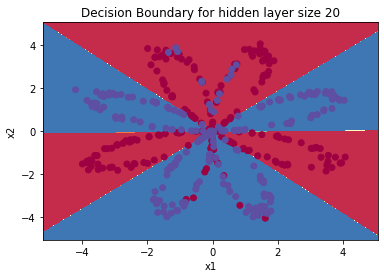

In [15]:
plot_decision_boundary(lambda x: predict(up, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(20))